# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from bresenham import bresenham
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

# Global variables

In [2]:
STEP = 1 # step of emitter in degrees
NUMBER_OF_DETECTORS = 90
DETECTORS_RANGE = 90 # degrees
RANGE = 360 # iterations - whole cirlce
RADIUS = int() # initialized and compute after image is loaded
SOURCE = "photos/Shepp_logan.jpg"

# Main

In [3]:
def main():
    image = rgb2gray(imread(SOURCE))
    resized = resize(image, (len(image) / 4, len(image[0]) / 4))
    new_edge = int(math.sqrt(2) * max(len(resized), len(resized[0])))
    radius = int(new_edge / 2)

    image = np.zeros([new_edge, new_edge])
    image[radius - int(len(resized) / 2) : radius + int(len(resized) / 2), radius - int(len(resized[0]) / 2) : radius + int(len(resized[0]) / 2)] = resized

    global RADIUS     
    RADIUS = int(len(image) / 2) - 1

    display_image(image, "Zdjęcie wejściowe")

    
    sinogram = make_sinogram(image)
    normalized_sinogram = normalize(sinogram)
    display_image(normalized_sinogram, "Sinogram")
    
    reverse_sinogram = make_reverse_sinogram(sinogram, [image.shape[0], image.shape[1]])
    reverse_sinogram = reverse_sinogram[int(image.shape[0] / 4) : int(3 * image.shape[0] / 4), int(image.shape[1] / 4) : int(3 * image.shape[1] / 4)]

    normalized_reverse_sinogram = normalize(reverse_sinogram)
    display_image(reverse_sinogram, "Reverse Sinogram")

# Functions

### Display Image

In [4]:
def display_image(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

### Emiter position

In [5]:
def set_emitter_position(angle):
    x = RADIUS * math.cos(math.radians(angle)) + RADIUS
    y = RADIUS * math.sin(math.radians(angle)) + RADIUS
    return [round(x), round(y)]

### Detectors positions

In [6]:
def set_detectors_positions(angle):
    result = list()
    
    for i in range(NUMBER_OF_DETECTORS): # cos by tu trzeba uproscic, ale chyba dziala
        x = RADIUS * math.cos(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        y = RADIUS * math.sin(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        result.append([round(x + RADIUS), round(y + RADIUS)])
    
    return result

### All positions

In [7]:
def set_positions():
    emitters = list()
    detectors = list()
    
    for i in range (0, RANGE, STEP):
        emitters.append(set_emitter_position(i))
        detectors.append(set_detectors_positions(i))
        
    return emitters, detectors

### Sinogram

In [8]:
def make_sinogram(image):
    emitters, detectors = set_positions()
    sinogram = np.zeros([len(emitters), NUMBER_OF_DETECTORS])

    for i in range(len(emitters)):
        for j in range(len(detectors[i])):
            line = bresenham(emitters[i][0], emitters[i][1], detectors[i][j][0], detectors[i][j][1])
            
            for element in line:
                sinogram[i, j] += image[element[0], element[1]]
            
    return sinogram 

### Reverse Sinogram

In [9]:
def make_reverse_sinogram(image, dimensions):
    emitters, detectors = set_positions()
    
    reverse_sinogram = np.zeros(dimensions)
    reverseCounter = np.zeros(dimensions)
    for i in range(len(emitters)):
        for j in range(len(detectors[i])):
            line = bresenham(emitters[i][0], emitters[i][1], detectors[i][j][0], detectors[i][j][1])
            
            for element in line:
                reverse_sinogram[element[0], element[1]] += image[i][j]
                
    return reverse_sinogram

### Normalize

In [10]:
def normalize(image):
    min_value = np.min(image)
    max_value = np.max(image)
    for i in range(len(image)):
        for j in range(len(image[i])):
            image[i, j] = (image[i, j] - min_value) / (max_value - min_value) * 255   
    return image

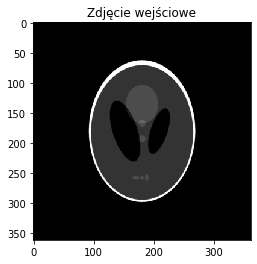

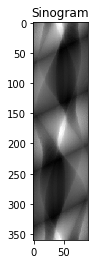

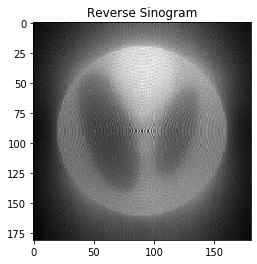

In [11]:
main()